In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Note:** The terms "soft" and "hard" are commonly used in classification tasks, not regression. So convert the target attribute into categorical and implement the hard and soft voting classifiers.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

insurance_df = pd.read_csv('insurance.csv')
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
insurance_df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [4]:
print("Insurance Cost Data Shape:",insurance_df.shape)
print("\nInformation of Insurance Cost:\n")
insurance_df.info()
print("\nStatistical Analysis of Insurance Cost:\n")
insurance_df.describe()

Insurance Cost Data Shape: (1338, 7)

Information of Insurance Cost:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Statistical Analysis of Insurance Cost:



,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
insurance_df['charges'].value_counts()

,count
charges,
1639.56310,2
2221.56445,1
19798.05455,1
13063.88300,1
13555.00490,1
...,...
1149.39590,1
37079.37200,1
4738.26820,1


### Dropping Null and Duplicates

In [6]:
print("NaN values present in Insurance Cost: ",insurance_df.isnull().values.sum())
print("Duplicates present in Insurance Cost: ",insurance_df.duplicated().sum())
insurance_df = insurance_df.drop_duplicates(keep='first')
print("Final Duplicates Count: ",insurance_df.duplicated().sum())

NaN values present in Insurance Cost:  0
Duplicates present in Insurance Cost:  1
Final Duplicates Count:  0


### Plots for Insurance Cost Prediction

Histogram - Target

<Axes: xlabel='charges', ylabel='Count'>

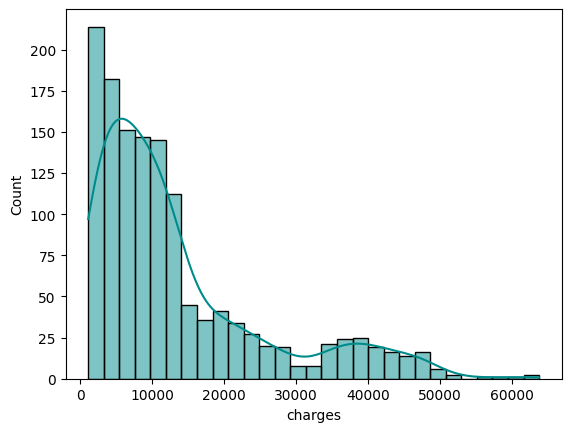

In [7]:
sns.histplot(insurance_df['charges'], kde=True, color='darkcyan')

Histogram - Bmi

<Axes: xlabel='bmi', ylabel='Count'>

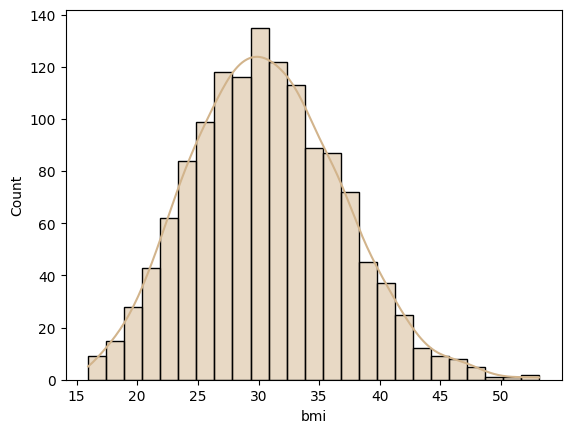

In [8]:
sns.histplot(insurance_df['bmi'], kde=True, color='tan')

Pie Chart - Region

<Axes: ylabel='count'>

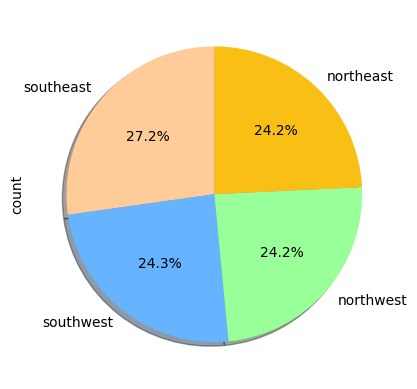

In [9]:
insurance_df['region'].value_counts().plot.pie(autopct='%1.1f%%',startangle=90,shadow=True, colors=['#ffcc99', '#66b3ff', '#99ff99', '#fabf15'])

Pie Chart - Smoker

<Axes: ylabel='count'>

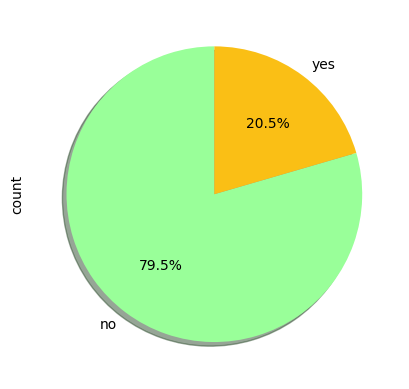

In [10]:
insurance_df['smoker'].value_counts().plot.pie(autopct='%1.1f%%',startangle=90,shadow=True, colors=['#99ff99', '#fabf15'])

Separating Categories using Quantile

In [11]:
insurance_Q1 = insurance_df['charges'].quantile(0.25)
#insurance_Q2 = insurance_df['charges'].median()   # or quantile(0.5)
insurance_Q2 = insurance_df['charges'].quantile(0.50)
insurance_Q3 = insurance_df['charges'].quantile(0.75)

print(f"Charges - 25% (Q1): {insurance_Q1}, \nCharges - 50% (Q2): {insurance_Q2}, \nCharges - 75% (Q3): {insurance_Q3}")


Charges - 25% (Q1): 4746.344, 
Charges - 50% (Q2): 9386.1613, 
Charges - 75% (Q3): 16657.71745


In [12]:
def categorize_charge(charge):
    if charge <= insurance_Q1:
        return 'Low'
    elif charge <= insurance_Q3:
        return 'Medium'
    else:
        return 'High'

insurance_df['charges_category'] = insurance_df['charges'].apply(categorize_charge)
insurance_df

,age,sex,bmi,children,smoker,region,charges,charges_category
0,19,female,27.900,0,yes,southwest,16884.92400,High
1,18,male,33.770,1,no,southeast,1725.55230,Low
2,28,male,33.000,3,no,southeast,4449.46200,Low
3,33,male,22.705,0,no,northwest,21984.47061,High
4,32,male,28.880,0,no,northwest,3866.85520,Low
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,Medium
1334,18,female,31.920,0,no,northeast,2205.98080,Low
1335,18,female,36.850,0,no,southeast,1629.83350,Low
1336,21,female,25.800,0,no,southwest,2007.94500,Low


In [13]:
insurance_df['charges_category'].value_counts()

,count
charges_category,
Medium,668
Low,335
High,334


Count plot

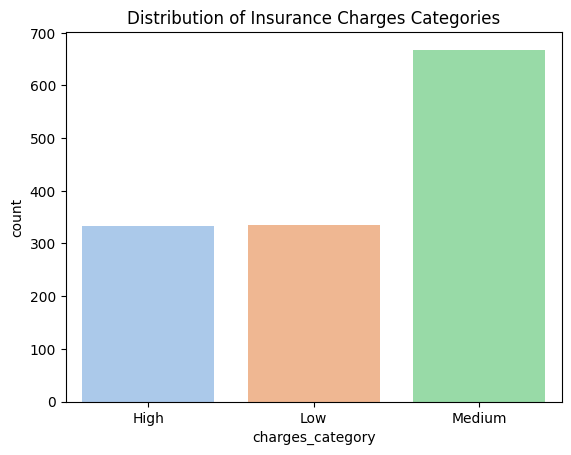

In [14]:
# count plot distribution
sns.countplot(data=insurance_df, x='charges_category', palette='pastel')
plt.title('Distribution of Insurance Charges Categories')
plt.show()

Box Plot

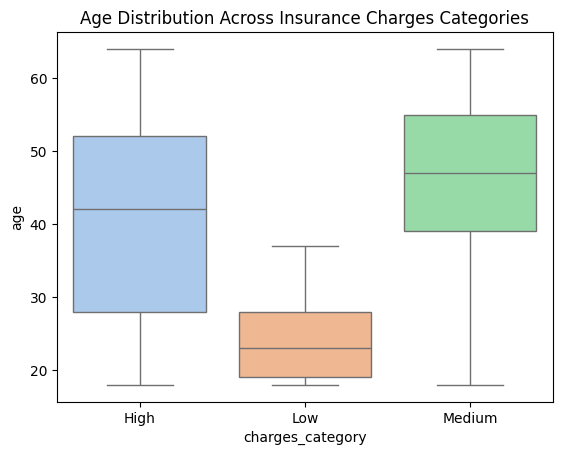

In [15]:
# Boxplot for age distribution across charges_category
sns.boxplot(data=insurance_df, x='charges_category', y='age', palette='pastel')
plt.title('Age Distribution Across Insurance Charges Categories')
plt.show()

Violin Plot

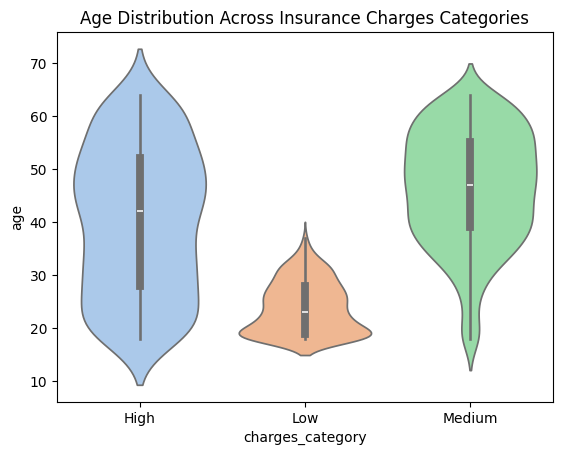

In [16]:
sns.violinplot(data=insurance_df, x='charges_category', y='age', palette='pastel')
plt.title('Age Distribution Across Insurance Charges Categories')
plt.show()

In [17]:
del insurance_df['charges']
# One-hot encoding for 'sex', 'smoker', and 'region' columns
insurance_df = pd.get_dummies(insurance_df, columns=['sex', 'smoker', 'region'], drop_first=False)
insurance_df

,age,bmi,children,charges_category,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,High,True,False,False,True,False,False,False,True
1,18,33.770,1,Low,False,True,True,False,False,False,True,False
2,28,33.000,3,Low,False,True,True,False,False,False,True,False
3,33,22.705,0,High,False,True,True,False,False,True,False,False
4,32,28.880,0,Low,False,True,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,Medium,False,True,True,False,False,True,False,False
1334,18,31.920,0,Low,True,False,True,False,True,False,False,False
1335,18,36.850,0,Low,True,False,True,False,False,False,True,False
1336,21,25.800,0,Low,True,False,True,False,False,False,False,True


In [18]:
insurance_df['charges_category'].value_counts()

,count
charges_category,
Medium,668
Low,335
High,334


Balance the data using SMOTE

Splitting

In [19]:
from collections import Counter
from imblearn.over_sampling import SMOTE

insuranceX = insurance_df.drop('charges_category',axis=1)
insuranceY = insurance_df['charges_category']

# Splitting (train 60%, test 20%, validation 20%)
ins_Xtr, ins_Xts, ins_Ytr, ins_Yts = train_test_split(insuranceX, insuranceY, test_size=0.4, random_state=20)
ins_Xva, ins_Xts, ins_Yva, ins_Yts = train_test_split(ins_Xts, ins_Yts, test_size=0.5, random_state=20)
print("Training Insurance Charges Data Shape:", ins_Xtr.shape, ins_Ytr.shape)
print("Testing Insurance Charges Data Shape:", ins_Xts.shape, ins_Yts.shape)
print("Validation Insurance Charges Data Shape:", ins_Xva.shape, ins_Yva.shape)

Training Insurance Charges Data Shape: (802, 11) (802,)
Testing Insurance Charges Data Shape: (268, 11) (268,)
Validation Insurance Charges Data Shape: (267, 11) (267,)


In [20]:
print('Insurance Charges Training Categories before balancing %s' % Counter(ins_Ytr))
smote_model = SMOTE()
ins_Xtr, ins_Ytr = smote_model.fit_resample(ins_Xtr, ins_Ytr)
print('Insurance Charges Training Categories after balancing %s' % Counter(ins_Ytr))

Insurance Charges Training Categories before balancing Counter({'Medium': 394, 'Low': 204, 'High': 204})
Insurance Charges Training Categories after balancing Counter({'Medium': 394, 'Low': 394, 'High': 394})


In [21]:
print("Training Data after balancing:\n")
print("Training Insurance Charges Data Shape:", ins_Xtr.shape, ins_Ytr.shape)

Training Data after balancing:

Training Insurance Charges Data Shape: (1182, 11) (1182,)


In [22]:
ins_Xtr

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,53,24.320000,0,False,True,True,False,False,True,False,False
1,31,30.875000,0,False,True,True,False,True,False,False,False
2,28,24.300000,5,False,True,True,False,False,False,False,True
3,38,19.475000,2,True,False,True,False,False,True,False,False
4,26,29.920000,1,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
1177,18,38.930800,0,True,False,True,False,False,False,True,False
1178,32,24.379434,0,True,True,True,False,False,True,True,False
1179,19,20.706208,0,False,True,True,False,False,True,False,False
1180,19,25.572682,1,True,True,True,False,False,True,False,False


In [23]:
ins_Xts

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
1,18,33.770,1,False,True,True,False,False,False,True,False
1013,48,32.300,1,False,True,True,False,False,True,False,False
1207,36,33.400,2,False,True,False,True,False,False,False,True
773,19,28.880,0,True,False,False,True,False,True,False,False
1057,45,31.790,0,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
605,51,34.100,0,True,False,True,False,False,False,True,False
1318,35,39.710,4,False,True,True,False,True,False,False,False
420,64,33.880,0,False,True,False,True,False,False,True,False
1186,20,35.625,3,False,True,False,True,False,True,False,False


In [24]:
ins_Xva

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
790,39,41.800,0,True,False,True,False,False,False,True,False
450,39,29.600,4,False,True,True,False,False,False,False,True
313,49,35.860,0,False,True,True,False,False,False,True,False
1118,33,35.750,1,False,True,False,True,False,False,True,False
813,28,22.515,2,False,True,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
244,63,27.740,0,True,False,False,True,True,False,False,False
530,57,42.130,1,False,True,False,True,False,False,True,False
165,47,28.215,4,False,True,True,False,True,False,False,False
1219,38,30.210,3,True,False,True,False,False,True,False,False


In [25]:
ins_Ytr

,charges_category
0,Medium
1,Low
2,Medium
3,Medium
4,Low
...,...
1177,Low
1178,Low
1179,Low
1180,Low


In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

### Gradient Boosting Classifier

Chosen Parameters by GB Classifier:

{'criterion': 'squared_error', 'loss': 'log_loss', 'n_estimators': 30}

==Validation of Gradient Boosting==

              precision    recall  f1-score   support

        High       0.98      0.82      0.89        66
         Low       0.85      0.95      0.90        66
      Medium       0.92      0.94      0.93       135

    accuracy                           0.91       267
   macro avg       0.92      0.90      0.91       267
weighted avg       0.92      0.91      0.91       267



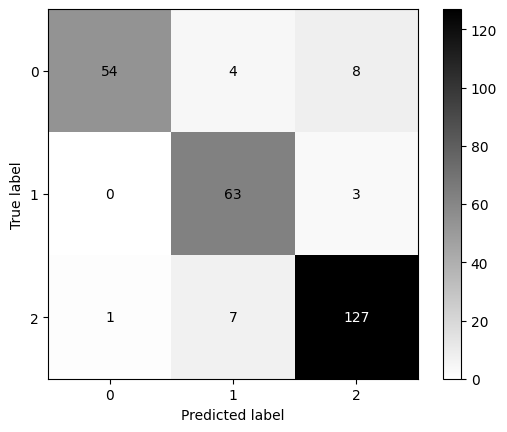


==Testing of Gradient Boosting==

              precision    recall  f1-score   support

        High       0.89      0.64      0.75        64
         Low       0.82      0.97      0.89        65
      Medium       0.88      0.92      0.90       139

    accuracy                           0.87       268
   macro avg       0.86      0.84      0.84       268
weighted avg       0.87      0.87      0.86       268



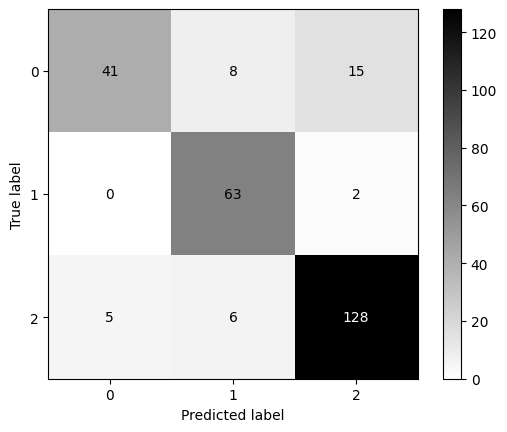

In [27]:
# train, validation and testing of Gradient Boosting Classifier

from sklearn.ensemble import GradientBoostingClassifier

ins_params_classif = { 'loss':['exponential', 'log_loss'],
                      'n_estimators': [100, 30, 50, 80],
                      'criterion': ['friedman_mse', 'squared_error']
                    }

ins_model_gbc = GradientBoostingClassifier()
ins_model_gbc = GridSearchCV(ins_model_gbc, ins_params_classif, cv=2)
ins_model_gbc.fit(ins_Xtr, ins_Ytr)
print("Chosen Parameters by GB Classifier:\n")
print(ins_model_gbc.best_params_)

ins_model_gbc = ins_model_gbc.best_estimator_
ins_model_gbc.fit(ins_Xtr, ins_Ytr)

ins_Ypred = ins_model_gbc.predict(ins_Xva)
print("\n==Validation of Gradient Boosting==\n")
print(classification_report(ins_Yva, ins_Ypred))
confus_matrix = confusion_matrix(ins_Yva, ins_Ypred)
ConfusionMatrixDisplay(confusion_matrix = confus_matrix, display_labels = [0,1,2]).plot(cmap='binary')
plt.show()

ins_Ypred = ins_model_gbc.predict(ins_Xts)
print("\n==Testing of Gradient Boosting==\n")
print(classification_report(ins_Yts, ins_Ypred))
confus_matrix = confusion_matrix(ins_Yts, ins_Ypred)
ConfusionMatrixDisplay(confusion_matrix = confus_matrix, display_labels = [0,1,2]).plot(cmap='binary')
plt.show()

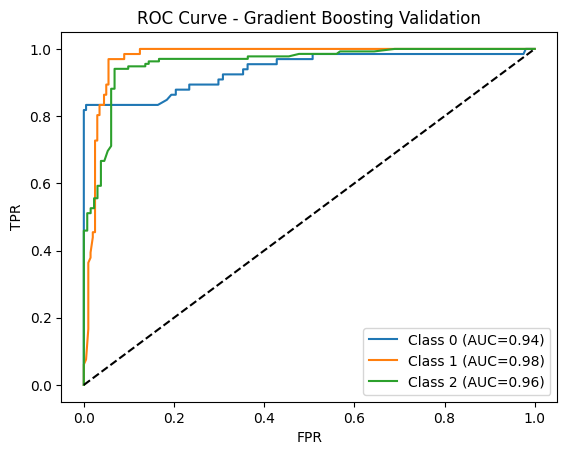

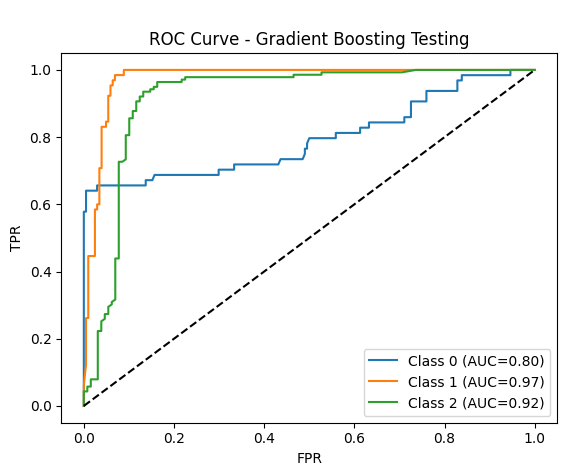

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# Binarize true labels for validation
y_bin_val = label_binarize(ins_Yva, classes=['High','Low','Medium'])
y_prob_val = ins_model_gbc.predict_proba(ins_Xva)

for i in range(y_bin_val.shape[1]):
    fpr, tpr, _ = roc_curve(y_bin_val[:, i], y_prob_val[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curve - Gradient Boosting Validation")
plt.legend()
plt.show()


# Binarize true labels for testing
y_bin_tst = label_binarize(ins_Yts, classes=['High','Low','Medium'])
y_prob_tst = ins_model_gbc.predict_proba(ins_Xts)

for i in range(y_bin_tst.shape[1]):
    fpr, tpr, _ = roc_curve(y_bin_tst[:, i], y_prob_tst[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("\nROC Curve - Gradient Boosting Testing")
plt.legend()
plt.show()


### Decision Tree Classifier

Chosen Parameters by DT Classifier:

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}

==Validation of Decision Tree==

              precision    recall  f1-score   support

        High       0.98      0.82      0.89        66
         Low       0.85      0.92      0.88        66
      Medium       0.91      0.94      0.92       135

    accuracy                           0.91       267
   macro avg       0.91      0.89      0.90       267
weighted avg       0.91      0.91      0.91       267



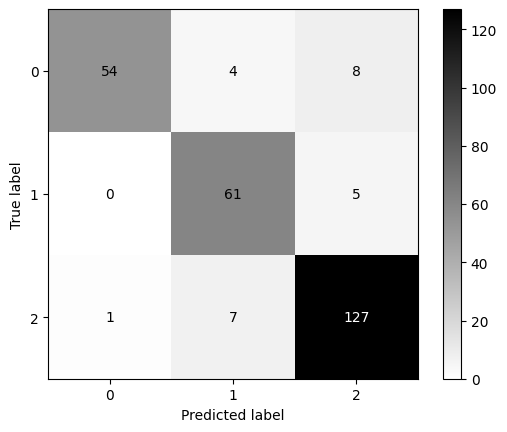


==Testing of Decision Tree==

              precision    recall  f1-score   support

        High       0.98      0.64      0.77        64
         Low       0.83      0.97      0.89        65
      Medium       0.89      0.96      0.92       139

    accuracy                           0.88       268
   macro avg       0.90      0.86      0.86       268
weighted avg       0.89      0.88      0.88       268



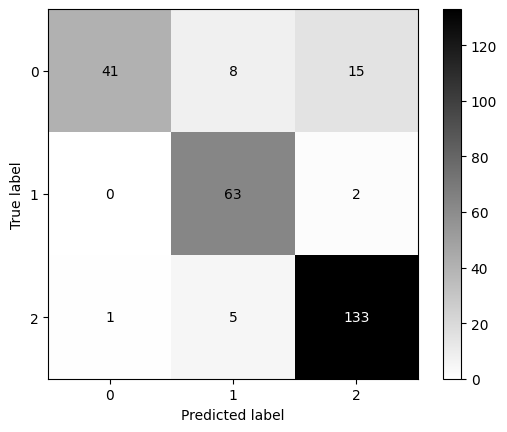

In [29]:
# train, validation and testing of Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier

ins_params_classif = { 'min_samples_split':[1, 2, 5, 6],
                      'max_depth': [10, 3, 5, 8],
                      'criterion': ['gini', 'entropy', 'log_loss']
                    }

ins_model_dtc = DecisionTreeClassifier()
ins_model_dtc = GridSearchCV(ins_model_dtc, ins_params_classif, cv=2)
ins_model_dtc.fit(ins_Xtr, ins_Ytr)
print("Chosen Parameters by DT Classifier:\n")
print(ins_model_dtc.best_params_)

ins_model_dtc = ins_model_dtc.best_estimator_
ins_model_dtc.fit(ins_Xtr, ins_Ytr)

ins_Ypred = ins_model_dtc.predict(ins_Xva)
print("\n==Validation of Decision Tree==\n")
print(classification_report(ins_Yva, ins_Ypred))
confus_matrix = confusion_matrix(ins_Yva, ins_Ypred)
ConfusionMatrixDisplay(confusion_matrix = confus_matrix, display_labels = [0,1,2]).plot(cmap='binary')
plt.show()

ins_Ypred = ins_model_dtc.predict(ins_Xts)
print("\n==Testing of Decision Tree==\n")
print(classification_report(ins_Yts, ins_Ypred))
confus_matrix = confusion_matrix(ins_Yts, ins_Ypred)
ConfusionMatrixDisplay(confusion_matrix = confus_matrix, display_labels = [0,1,2]).plot(cmap='binary')
plt.show()

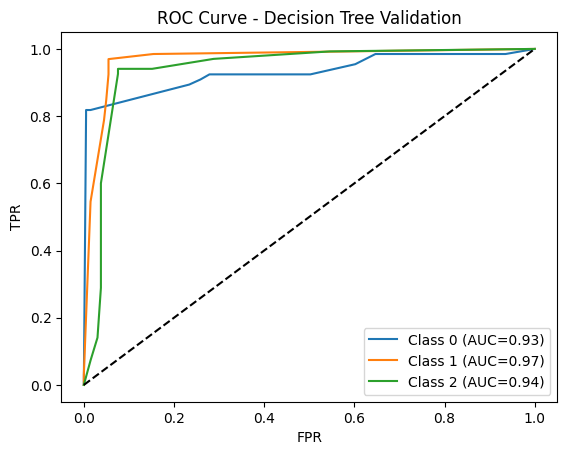

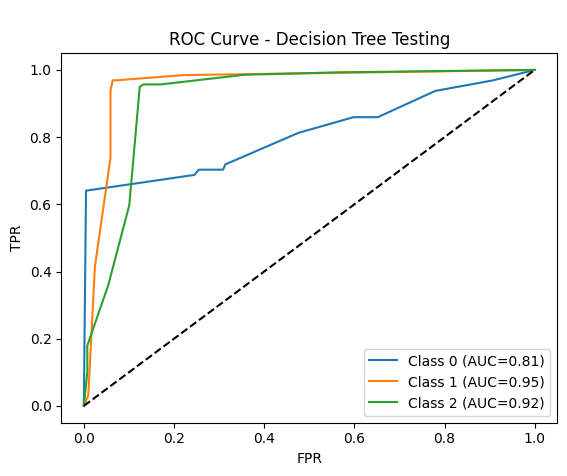

In [30]:
# Binarize true labels for validation
y_bin_val = label_binarize(ins_Yva, classes=['High','Low','Medium'])
y_prob_val = ins_model_dtc.predict_proba(ins_Xva)

for i in range(y_bin_val.shape[1]):
    fpr, tpr, _ = roc_curve(y_bin_val[:, i], y_prob_val[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curve - Decision Tree Validation")
plt.legend()
plt.show()


# Binarize true labels for testing
y_bin_tst = label_binarize(ins_Yts, classes=['High','Low','Medium'])
y_prob_tst = ins_model_dtc.predict_proba(ins_Xts)

for i in range(y_bin_tst.shape[1]):
    fpr, tpr, _ = roc_curve(y_bin_tst[:, i], y_prob_tst[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("\nROC Curve - Decision Tree Testing")
plt.legend()
plt.show()

### Random Forest Classifier

Chosen Parameters by RF Classifier:

{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 80}

==Validation of Random Forest==

              precision    recall  f1-score   support

        High       0.93      0.83      0.88        66
         Low       0.85      0.97      0.91        66
      Medium       0.93      0.92      0.93       135

    accuracy                           0.91       267
   macro avg       0.91      0.91      0.90       267
weighted avg       0.91      0.91      0.91       267



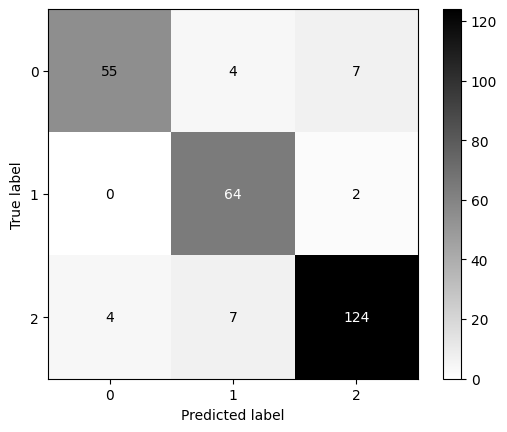


==Testing of Random Forest==

              precision    recall  f1-score   support

        High       0.91      0.64      0.75        64
         Low       0.79      0.95      0.87        65
      Medium       0.88      0.92      0.90       139

    accuracy                           0.86       268
   macro avg       0.86      0.84      0.84       268
weighted avg       0.87      0.86      0.86       268



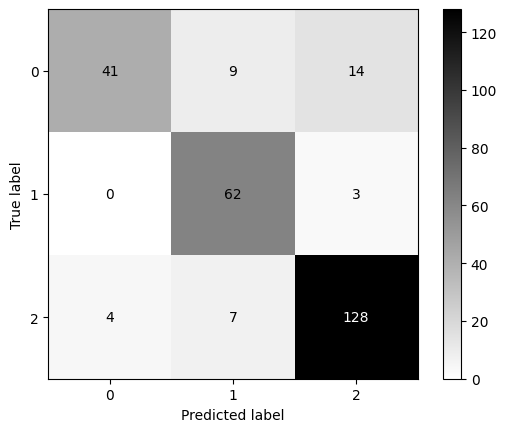

In [31]:
# train, validation and testing of Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

ins_params_classif = { 'max_depth':[10, 3, 5, 8],
                   'n_estimators': [100, 30, 50, 80],
                   'criterion': ['gini', 'entropy', 'log_loss']}

ins_model_rfc = RandomForestClassifier()
ins_model_rfc = GridSearchCV(ins_model_rfc, ins_params_classif, cv=2)
ins_model_rfc.fit(ins_Xtr, ins_Ytr)
print("Chosen Parameters by RF Classifier:\n")
print(ins_model_rfc.best_params_)

ins_model_rfc = ins_model_rfc.best_estimator_
ins_model_rfc.fit(ins_Xtr, ins_Ytr)

ins_Ypred = ins_model_rfc.predict(ins_Xva)
print("\n==Validation of Random Forest==\n")
print(classification_report(ins_Yva, ins_Ypred))
confus_matrix = confusion_matrix(ins_Yva, ins_Ypred)
ConfusionMatrixDisplay(confusion_matrix = confus_matrix, display_labels = [0,1,2]).plot(cmap='binary')
plt.show()

ins_Ypred = ins_model_rfc.predict(ins_Xts)
print("\n==Testing of Random Forest==\n")
print(classification_report(ins_Yts, ins_Ypred))
confus_matrix = confusion_matrix(ins_Yts, ins_Ypred)
ConfusionMatrixDisplay(confusion_matrix = confus_matrix, display_labels = [0,1,2]).plot(cmap='binary')
plt.show()

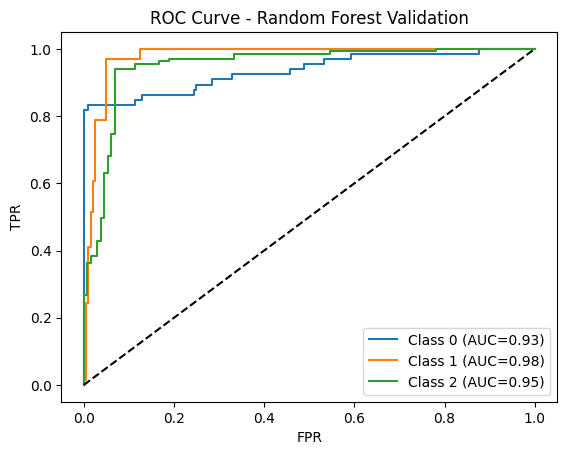

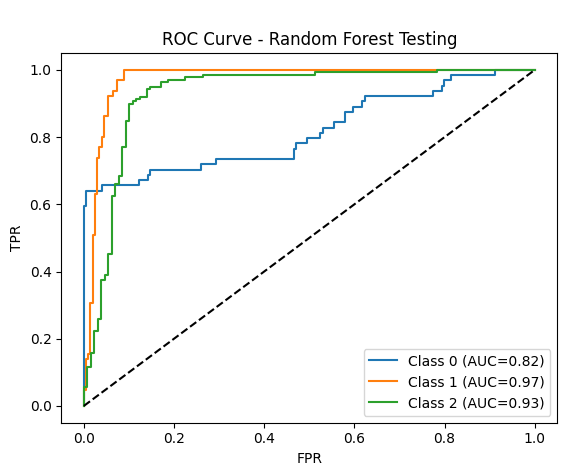

In [32]:
# Binarize true labels for validation
y_bin_val = label_binarize(ins_Yva, classes=['High','Low','Medium'])
y_prob_val = ins_model_rfc.predict_proba(ins_Xva)

for i in range(y_bin_val.shape[1]):
    fpr, tpr, _ = roc_curve(y_bin_val[:, i], y_prob_val[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curve - Random Forest Validation")
plt.legend()
plt.show()


# Binarize true labels for testing
y_bin_tst = label_binarize(ins_Yts, classes=['High','Low','Medium'])
y_prob_tst = ins_model_rfc.predict_proba(ins_Xts)

for i in range(y_bin_tst.shape[1]):
    fpr, tpr, _ = roc_curve(y_bin_tst[:, i], y_prob_tst[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("\nROC Curve - Random Forest Testing")
plt.legend()
plt.show()

### Using 'hard' Voting Classifier Combinations


==Validation of GBC, DTC and RFC using Hard Voting==

              precision    recall  f1-score   support

        High       0.95      0.83      0.89        66
         Low       0.85      0.97      0.91        66
      Medium       0.93      0.93      0.93       135

    accuracy                           0.91       267
   macro avg       0.91      0.91      0.91       267
weighted avg       0.92      0.91      0.91       267



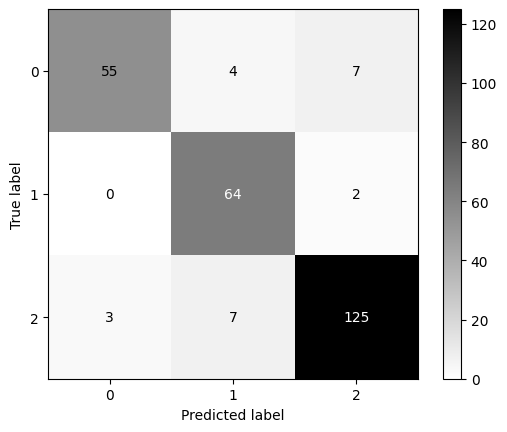


==Testing of GBC, DTC and RFC using Hard Voting==

              precision    recall  f1-score   support

        High       0.89      0.64      0.75        64
         Low       0.81      0.97      0.88        65
      Medium       0.89      0.92      0.90       139

    accuracy                           0.87       268
   macro avg       0.86      0.84      0.84       268
weighted avg       0.87      0.87      0.86       268



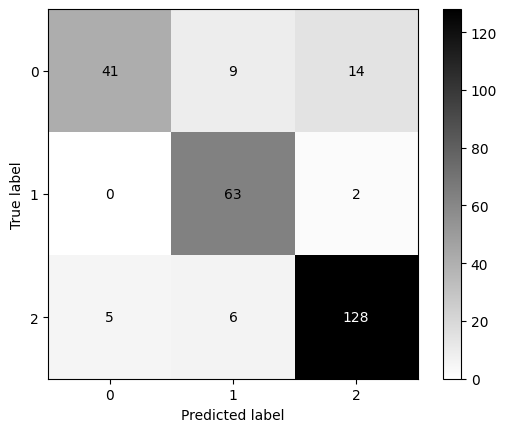

In [33]:
# train, validation and testing of Hard Voting
from sklearn.ensemble import VotingClassifier

ins_model_gbc = GradientBoostingClassifier(criterion= 'squared_error', loss= 'log_loss', n_estimators= 30)
ins_model_dtc = DecisionTreeClassifier(criterion= 'log_loss', max_depth= 5, min_samples_split= 2)
ins_model_rfc = RandomForestClassifier(criterion= 'log_loss', max_depth= 5, n_estimators= 50)
ins_model = VotingClassifier(estimators=[('GBC', ins_model_gbc), ('DTC', ins_model_dtc), ('RFC', ins_model_rfc)], voting='hard')
ins_model.fit(ins_Xtr, ins_Ytr)

ins_Ypred = ins_model.predict(ins_Xva)
print("\n==Validation of GBC, DTC and RFC using Hard Voting==\n")
print(classification_report(ins_Yva, ins_Ypred))
confus_matrix = confusion_matrix(ins_Yva, ins_Ypred)
ConfusionMatrixDisplay(confusion_matrix = confus_matrix, display_labels = [0,1,2]).plot(cmap='binary')
plt.show()

ins_Ypred = ins_model.predict(ins_Xts)
print("\n==Testing of GBC, DTC and RFC using Hard Voting==\n")
print(classification_report(ins_Yts, ins_Ypred))
confus_matrix = confusion_matrix(ins_Yts, ins_Ypred)
ConfusionMatrixDisplay(confusion_matrix = confus_matrix, display_labels = [0,1,2]).plot(cmap='binary')
plt.show()

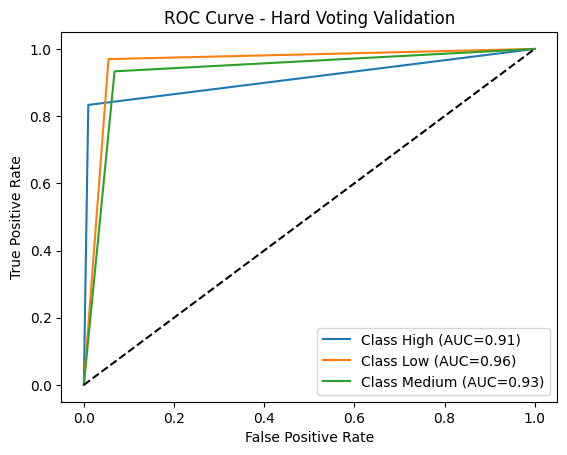

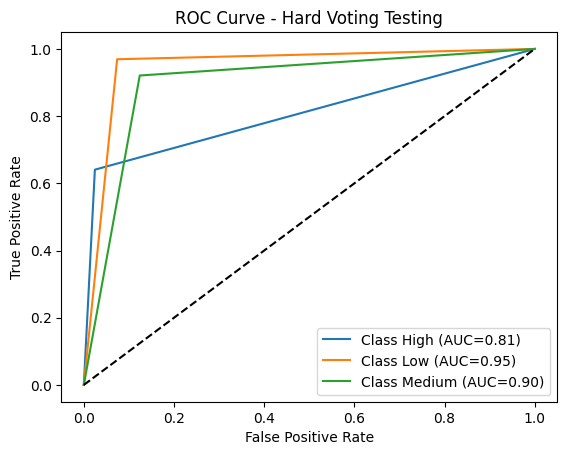

In [34]:
# Use Hard voting for ROC
ins_model = VotingClassifier(
    estimators=[('GBC', ins_model_gbc), ('DTC', ins_model_dtc), ('RFC', ins_model_rfc)],
    voting='hard'
)
ins_model.fit(ins_Xtr, ins_Ytr)

# Predict hard labels
y_pred_val = ins_model.predict(ins_Xva)

# Binarize labels (OvR scheme)
classes = ['High','Low','Medium']
y_bin_val = label_binarize(ins_Yva, classes=classes)
y_bin_pred = label_binarize(y_pred_val, classes=classes)

# Plot ROC curves (step-like)

for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin_val[:, i], y_bin_pred[:, i])
    plt.plot(fpr, tpr, label=f"Class {c} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Hard Voting Validation")
plt.legend()
plt.show()

# ================= Testing ROC =================
y_pred_tst = ins_model.predict(ins_Xts)

# Binarize labels (OvR scheme)
classes = ['High','Low','Medium']
y_bin_tst = label_binarize(ins_Yts, classes=classes)
y_bin_pred = label_binarize(y_pred_tst, classes=classes)

# Plot ROC curves (step-like)

for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin_tst[:, i], y_bin_pred[:, i])
    plt.plot(fpr, tpr, label=f"Class {c} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Hard Voting Testing")
plt.legend()
plt.show()

### Using 'soft' Voting Classifier Combinations


==Validation of GBC, DTC and RFC using Soft Voting==

              precision    recall  f1-score   support

        High       0.98      0.82      0.89        66
         Low       0.83      0.97      0.90        66
      Medium       0.93      0.93      0.93       135

    accuracy                           0.91       267
   macro avg       0.91      0.90      0.90       267
weighted avg       0.92      0.91      0.91       267



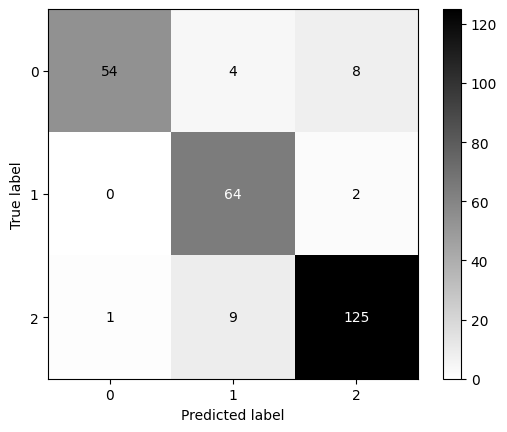


==Testing of GBC, DTC and RFC using Soft Voting==

              precision    recall  f1-score   support

        High       0.98      0.64      0.77        64
         Low       0.81      0.97      0.88        65
      Medium       0.89      0.95      0.92       139

    accuracy                           0.88       268
   macro avg       0.89      0.85      0.86       268
weighted avg       0.89      0.88      0.88       268



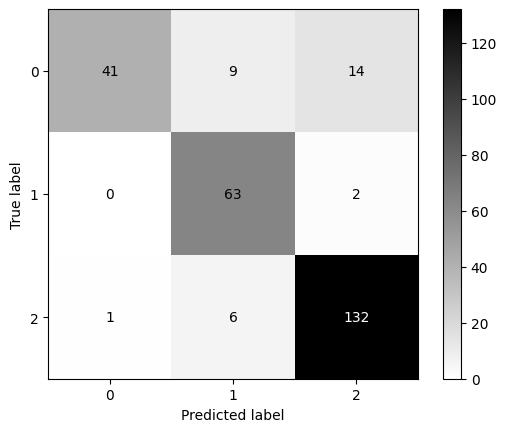

In [35]:
# train, validation and testing of Soft Voting
from sklearn.ensemble import VotingClassifier

ins_model_gbc = GradientBoostingClassifier(criterion= 'squared_error', loss= 'log_loss', n_estimators= 30)
ins_model_dtc = DecisionTreeClassifier(criterion= 'log_loss', max_depth= 5, min_samples_split= 2)
ins_model_rfc = RandomForestClassifier(criterion= 'log_loss', max_depth= 5, n_estimators= 50)
ins_model = VotingClassifier(estimators=[('GBC', ins_model_gbc), ('DTC', ins_model_dtc), ('RFC', ins_model_rfc)], voting='soft')
ins_model.fit(ins_Xtr, ins_Ytr)

ins_Ypred = ins_model.predict(ins_Xva)
print("\n==Validation of GBC, DTC and RFC using Soft Voting==\n")
print(classification_report(ins_Yva, ins_Ypred))
confus_matrix = confusion_matrix(ins_Yva, ins_Ypred)
ConfusionMatrixDisplay(confusion_matrix = confus_matrix, display_labels = [0,1,2]).plot(cmap='binary')
plt.show()

ins_Ypred = ins_model.predict(ins_Xts)
print("\n==Testing of GBC, DTC and RFC using Soft Voting==\n")
print(classification_report(ins_Yts, ins_Ypred))
confus_matrix = confusion_matrix(ins_Yts, ins_Ypred)
ConfusionMatrixDisplay(confusion_matrix = confus_matrix, display_labels = [0,1,2]).plot(cmap='binary')
plt.show()

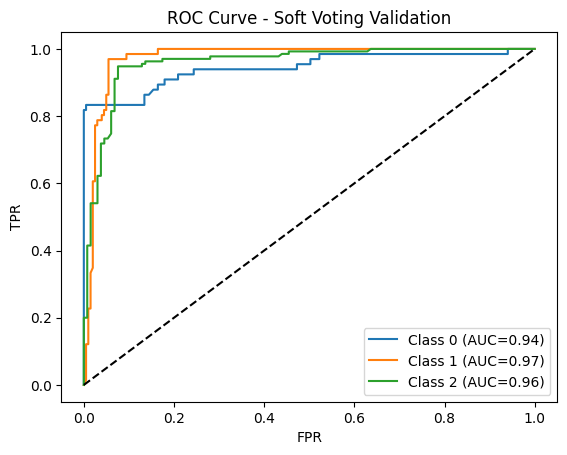

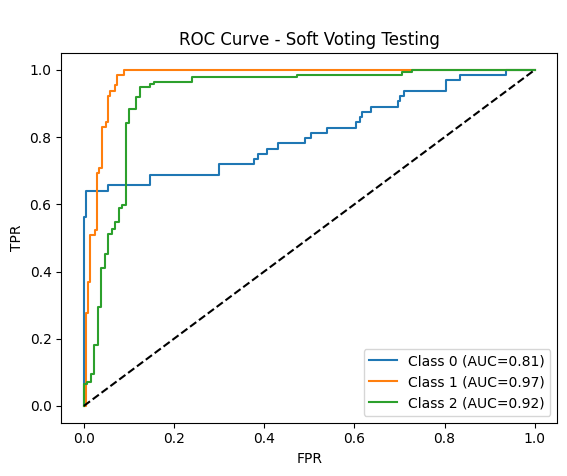

In [36]:
ins_model = VotingClassifier(
    estimators=[('GBC', ins_model_gbc), ('DTC', ins_model_dtc), ('RFC', ins_model_rfc)],
    voting='soft'
)
ins_model.fit(ins_Xtr, ins_Ytr)

# Binarize true labels for validation
y_bin_val = label_binarize(ins_Yva, classes=['High','Low','Medium'])
y_prob_val = ins_model.predict_proba(ins_Xva)

for i in range(y_bin_val.shape[1]):
    fpr, tpr, _ = roc_curve(y_bin_val[:, i], y_prob_val[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curve - Soft Voting Validation")
plt.legend()
plt.show()


# Binarize true labels for testing
y_bin_tst = label_binarize(ins_Yts, classes=['High','Low','Medium'])
y_prob_tst = ins_model.predict_proba(ins_Xts)

for i in range(y_bin_tst.shape[1]):
    fpr, tpr, _ = roc_curve(y_bin_tst[:, i], y_prob_tst[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("\nROC Curve - Soft Voting Testing")
plt.legend()
plt.show()